In [1]:
from datasets import load_dataset, Dataset, ClassLabel
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
import evaluate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import torch
from codecarbon import EmissionsTracker
from datasets import DatasetDict

In [2]:
tracker_training = EmissionsTracker()
tracker_training.start()

[codecarbon WARNING @ 13:47:39] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:47:39] [setup] RAM Tracking...
[codecarbon INFO @ 13:47:39] [setup] CPU Tracking...
[codecarbon WARNING @ 13:47:41] We saw that you have a AMD Ryzen 7 7700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon WARNING @ 13:47:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 13:47:41] CPU Model on constant consumption mode: AMD Ryzen 7 7700X 8-Core Processor
[codecarbon WARNING @ 13:47:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:47:41] [setup] GPU Tracking...
[codecarbon INFO @ 13:47:41] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:47:41] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking 

In [3]:
dataset	= load_dataset("wykonos/movies")
ds = dataset["train"].select_columns(["overview", "genres"]).to_pandas()

In [4]:
labels = pd.Series([i for l in ds["genres"].str.split("-") if l is not None for i in l]).unique()
mapper = {j: i for i, j in enumerate(labels)}
with open("labels.json", "w") as f:
    json.dump(mapper, f)
ds = ds.dropna()
ds["genres"] = ds["genres"].str.split("-").apply(lambda x: [mapper[i] for i in x])
ds["genres"] = ds["genres"].apply(lambda x: [1. if i in x else 0. for i in range(len(labels))])
ds.rename(columns={"overview": "text", "genres": "labels"}, inplace=True)
ds

,text,labels
0,Over many missions and against impossible odds...,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Father Gabriele Amorth Chief Exorcist of the V...,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Super-Hero partners Scott Lang and Hope van Dy...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
3,After dominating the boxing world Adonis Creed...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,While working underground to fix a water main ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
...,...,...
722782,Suburbia 1967. Eleven-year-old Susan Bradley h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
722786,Homage to the Puerto Rican composer Rafael Her...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
722788,"Japanese ""kayo"" film centered around the song ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
722790,Filipino Vietnam War movie,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
# Dividir en train/validation/test (80%-10%-10%)
ds = ds.sample(frac=1/3, random_state=42)  # Mezclar
train_df = ds[:int(0.75*len(ds))]
val_df = ds[int(0.75*len(ds)):int(0.9*len(ds))]
test_df = ds[int(0.9*len(ds)):]

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False)
})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 108926
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 21785
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 14524
    })
})

In [7]:
model_name = "microsoft/deberta-v3-small"
tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)
model = DebertaV2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mapper),  # Ajusta al número de géneros
    problem_type="multi_label_classification"
)

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest",
    max_length=512,  # Máximo de DeBERTa
)

# Tokenización (igual que antes)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512, padding=False)

tokenized_data = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/108926 [00:00<?, ? examples/s]

[codecarbon INFO @ 13:47:59] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:47:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:47:59] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 13:47:59] Energy consumed for all GPUs : 0.000045 kWh. Total GPU Power : 10.69311141895981 W
[codecarbon INFO @ 13:47:59] 0.000305 kWh of electricity used since the beginning.


Map:   0%|          | 0/21785 [00:00<?, ? examples/s]

Map:   0%|          | 0/14524 [00:00<?, ? examples/s]

In [8]:
cfl_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = sigmoid(logits)
    predictions = (predictions > 0.5).astype(int).reshape(-1)
    return cfl_metrics.compute(
        predictions=predictions,
        references=labels.astype(int).reshape(-1)
    )

[codecarbon INFO @ 13:48:14] Energy consumed for RAM : 0.000166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:48:14] Delta energy consumed for CPU with constant : 0.000175 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:14] Energy consumed for All CPU : 0.000353 kWh
[codecarbon INFO @ 13:48:14] Energy consumed for all GPUs : 0.000092 kWh. Total GPU Power : 11.3736953782554 W
[codecarbon INFO @ 13:48:14] 0.000610 kWh of electricity used since the beginning.


In [9]:
# Configuración del entrenamiento
training_args = TrainingArguments(
    output_dir="./deberta-results",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,  
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Entrenar
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()

C:\Users\david\AppData\Local\Temp\ipykernel_8948\1222508908.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon WARNING @ 13:48:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:48:16] [setup] RAM Tracking...
[codecarbon INFO @ 13:48:16] [setup] CPU Tracking...
[codecarbon WARNING @ 13:48:17] We saw that you have a AMD Ryzen 7 7700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon WARNING @ 13:48:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 13:48:17] CPU Model on constant consumption mode: AMD Ryzen 7 7700X 8-Core Processor
[codecarbon WARNING @ 13:48:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:48:17] [setup] GPU Tracking...
[code

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.160900,0.156077,0.940768,0.577781,0.726788,0.479478
2,0.145500,0.155623,0.941783,0.599618,0.716060,0.515749
3,0.130300,0.153716,0.941353,0.615104,0.690703,0.554422
4,0.118100,0.160195,0.942213,0.620484,0.697350,0.558881
5,0.106300,0.163347,0.942116,0.622080,0.694062,0.563625
6,0.096200,0.174239,0.940568,0.618841,0.675712,0.570800
7,0.084200,0.183837,0.940836,0.623078,0.675038,0.578546
8,0.075800,0.191070,0.940715,0.622576,0.673937,0.578489


[codecarbon INFO @ 13:48:29] Energy consumed for RAM : 0.000249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:48:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:29] Energy consumed for All CPU : 0.000530 kWh
[codecarbon INFO @ 13:48:29] Energy consumed for all GPUs : 0.000387 kWh. Total GPU Power : 70.99797698345833 W
[codecarbon INFO @ 13:48:29] 0.001166 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:48:35] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:48:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:48:35] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 13:48:35] Energy consumed for all GPUs : 0.000473 kWh. Total GPU Power : 113.41970621983737 W
[codecarbon INFO @ 13:48:35] 0.000734 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:48:44] Energy consumed for RAM : 0.000333 kWh. RAM Power : 

TrainOutput(global_step=72624, training_loss=0.1177413103653487, metrics={'train_runtime': 9753.3691, 'train_samples_per_second': 111.68, 'train_steps_per_second': 9.308, 'total_flos': 3.1413797381513136e+16, 'train_loss': 0.1177413103653487, 'epoch': 8.0})

In [10]:
# Evaluación final en el conjunto de test (opcional)
test_results = trainer.evaluate(tokenized_data["test"])
print("Resultados en Test:", test_results)

[codecarbon INFO @ 16:31:04] Energy consumed for RAM : 0.054396 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:31:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:04] Energy consumed for All CPU : 0.115634 kWh
[codecarbon INFO @ 16:31:04] Energy consumed for all GPUs : 0.353340 kWh. Total GPU Power : 108.29753756013422 W
[codecarbon INFO @ 16:31:04] 0.523370 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:31:19] Energy consumed for RAM : 0.054480 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:31:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:19] Energy consumed for All CPU : 0.115811 kWh
[codecarbon INFO @ 16:31:19] Energy consumed for all GPUs : 0.353987 kWh. Total GPU Power : 155.28024535840592 W
[codecarbon INFO @ 16:31:19] 0.524278 kWh of electricity used since the beginning.


Resultados en Test: {'eval_loss': 0.15494292974472046, 'eval_accuracy': 0.9406100972618824, 'eval_f1': 0.6113495695890346, 'eval_precision': 0.6883109948203129, 'eval_recall': 0.5498677587236583, 'eval_runtime': 37.8632, 'eval_samples_per_second': 383.591, 'eval_steps_per_second': 23.981, 'epoch': 8.0}


In [11]:
model.save_pretrained("./deberta-results/final_model")
tokenizer.save_pretrained("./deberta-results/final_tokenizer")
trainer.save_model("./deberta-results/final_trainer")

In [12]:
emissions = tracker_training.stop()
print(f"Emisiones de CO2 durante el entrenamiento: {emissions} kg")

[codecarbon INFO @ 16:31:34] Energy consumed for RAM : 0.054561 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:31:34] Delta energy consumed for CPU with constant : 0.000173 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:34] Energy consumed for All CPU : 0.115984 kWh
[codecarbon INFO @ 16:31:34] Energy consumed for all GPUs : 0.354466 kWh. Total GPU Power : 118.17478091686465 W
[codecarbon INFO @ 16:31:34] 0.525011 kWh of electricity used since the beginning.


Emisiones de CO2 durante el entrenamiento: 0.26630925451451704 kg


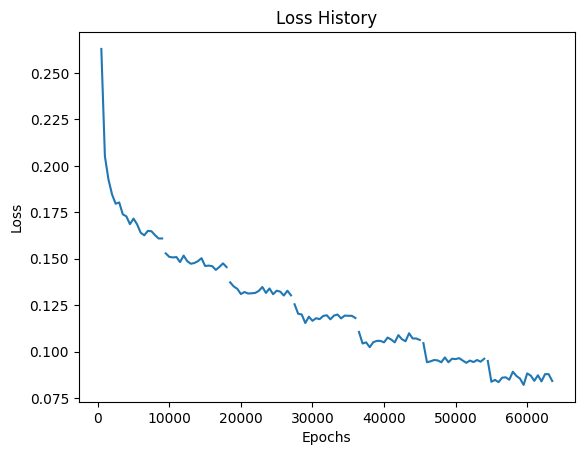

In [13]:
with open("./deberta-results/checkpoint-63546/trainer_state.json", "r") as f:
    trainer_state = json.load(f)

loss_history = pd.DataFrame(trainer_state['log_history'])

plt.plot(loss_history['step'], loss_history['loss'], label='Training Loss')
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [14]:
inference_tracker = EmissionsTracker()
inference_tracker.start()

[codecarbon WARNING @ 16:31:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:31:34] [setup] RAM Tracking...
[codecarbon INFO @ 16:31:34] [setup] CPU Tracking...
[codecarbon WARNING @ 16:31:35] We saw that you have a AMD Ryzen 7 7700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon WARNING @ 16:31:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 16:31:35] CPU Model on constant consumption mode: AMD Ryzen 7 7700X 8-Core Processor
[codecarbon WARNING @ 16:31:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:31:35] [setup] GPU Tracking...
[codecarbon INFO @ 16:31:35] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:31:35] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking 

In [15]:
r_model = DebertaV2ForSequenceClassification.from_pretrained("./deberta-results/final_model")
r_model.to("cuda")
r_tokenizer = DebertaV2Tokenizer.from_pretrained("./deberta-results/final_tokenizer")
with open("labels.json", "r") as f:
    mapper = json.load(f)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_genres(text, threshold=0.5):
    # Tokenizar el texto de entrada
    inputs = r_tokenizer(
        text,
        truncation=True,
        max_length=512,
        return_tensors="pt",
    ).to(device)
    
    # Pasar por el modelo
    with torch.no_grad():
        outputs = r_model(**inputs)
    
    # Convertir logits a probabilidades con sigmoid (para multi-etiqueta)
    probs = torch.sigmoid(outputs.logits)
    
    # Aplicar umbral para obtener predicciones binarias
    predictions = (probs > threshold).int().squeeze().tolist()
    
    # Mapear índices a nombres de géneros (ajusta según tu mapeo)
    genre_mapping = {v: k for k, v in mapper.items()}
    # Obtener géneros predichos
    predicted_genres = [genre_mapping[i] for i, pred in enumerate(predictions) if pred == 1]
    
    return predicted_genres, probs.cpu().numpy().tolist() 

# Ejemplo de uso
text = "A catholic priest is sent to a remote island to investigate the disappearance of a young priest. He finds the island is home to a cult that worships a demon."
predicted_genres, probabilities = predict_genres(text)
print(f"Predicted Genres: {predicted_genres}")

Predicted Genres: ['Horror']


In [17]:
emissions = inference_tracker.stop()
print(f"Emisiones de CO2 durante la inferencia: {emissions} kg")

[codecarbon INFO @ 16:31:39] Energy consumed for RAM : 0.000004 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:31:39] Delta energy consumed for CPU with constant : 0.000008 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:39] Energy consumed for All CPU : 0.000008 kWh
[codecarbon INFO @ 16:31:39] Energy consumed for all GPUs : 0.000005 kWh. Total GPU Power : 25.158048051134177 W
[codecarbon INFO @ 16:31:39] 0.000016 kWh of electricity used since the beginning.


Emisiones de CO2 durante la inferencia: 8.342673221740586e-06 kg
